In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.3 MB/s eta 0:00:00


In [12]:
!pip install torch transformers peft datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install transformers peft datasets accelerate bitsandbytes torch

In [ ]:
!pip install openpyxl

In [7]:
import pandas as pd
file_path = "dataEquilibre.xlsx"
df = pd.read_excel(file_path)

In [8]:
import pandas as pd
import re
import spacy
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
# Supprimer les doublons
df = df.drop_duplicates(subset=["description"], keep="first")
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Appliquer la fonction
df["description"] = df["description"].apply(clean_text)

In [9]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_mapping)

In [10]:
print(df["label"].value_counts())

label
0    330
1    330
2    330
Name: count, dtype: int64


In [13]:
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained("nickmuchi/deberta-v3-base-finetuned-finance-text-classification")

def preprocess_data(examples):
    return tokenizer(
        examples["description"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Conversion en Dataset Hugging Face
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data, batched=True)
dataset = dataset.remove_columns(["description"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch")
dataset = dataset.with_format("torch", columns=["input_ids", "attention_mask", "labels"])


tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/990 [00:00<?, ? examples/s]

In [ ]:
import torch
import optuna
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [14]:
from transformers import TrainingArguments, Trainer
from datasets import Dataset

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

In [15]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 792
Test dataset size: 198


In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification

model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)


lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cpu.so)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4

trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


#**Optuna**

In [ ]:
import optuna
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 50)
    lora_alpha = trial.suggest_int("lora_alpha", 8, 64)
    lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)

    # Mise à jour de la config LoRa
    lora_config.lora_alpha = lora_alpha
    lora_config.lora_dropout = lora_dropout

    model = get_peft_model(
        AutoModelForSequenceClassification.from_pretrained(
            "nickmuchi/deberta-v3-base-finetuned-finance-text-classification",
            num_labels=3
        ),
        lora_config
    )

    training_args = TrainingArguments(
        output_dir="./optuna_results",
        evaluation_strategy="epoch",
        save_strategy="no",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()

    # Évaluation
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    labels = test_dataset["labels"]
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    # Optuna va chercher à maximiser la métrique retournée
    return f1

# Création de l'étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", study.best_params)

[I 2025-02-11 08:18:41,943] A new study created in memory with name: no-name-67597387-c67d-4daf-872d-318d9046cc57
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-18-75182d2f76e9>:39: FutureWarning: `tokeniz

Epoch,Training Loss,Validation Loss
1,0.284400,0.192563
2,0.180900,0.117937
3,0.114900,0.139767
4,0.092600,0.155487
5,0.095700,0.155356
6,0.068900,0.197155
7,0.059200,0.200132
8,0.046800,0.210786
9,0.046700,0.213335
10,0.037200,0.255147


[I 2025-02-11 08:33:45,212] Trial 0 finished with value: 0.9635364478817722 and parameters: {'learning_rate': 0.0003908401310797169, 'batch_size': 16, 'num_train_epochs': 48, 'lora_alpha': 52, 'lora_dropout': 0.08876144106969232}. Best is trial 0 with value: 0.9635364478817722.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,No log,0.271027
2,0.421300,0.194527
3,0.421300,0.147591
4,0.221200,0.126375
5,0.221200,0.117014
6,0.171600,0.119163
7,0.171600,0.123837
8,0.146000,0.121968
9,0.146000,0.117559
10,0.122700,0.111712


[I 2025-02-11 08:40:39,929] Trial 1 finished with value: 0.9644373938540766 and parameters: {'learning_rate': 7.181752370110086e-05, 'batch_size': 32, 'num_train_epochs': 23, 'lora_alpha': 29, 'lora_dropout': 0.26657904323544523}. Best is trial 1 with value: 0.9644373938540766.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,No log,0.300575
2,0.499600,0.267425
3,0.499600,0.243060
4,0.325600,0.210110
5,0.325600,0.186044
6,0.271000,0.166953
7,0.271000,0.151395
8,0.225700,0.141700
9,0.225700,0.133446
10,0.181700,0.123837


[I 2025-02-11 08:52:59,570] Trial 2 finished with value: 0.9644373938540766 and parameters: {'learning_rate': 2.2805609957781287e-05, 'batch_size': 32, 'num_train_epochs': 41, 'lora_alpha': 37, 'lora_dropout': 0.05007855245423176}. Best is trial 1 with value: 0.9644373938540766.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depr

Epoch,Training Loss,Validation Loss
1,No log,0.275596
2,0.433600,0.208300
3,0.433600,0.163846
4,0.236500,0.139123
5,0.236500,0.123206
6,0.182300,0.124467
7,0.182300,0.132925
8,0.153400,0.128006
9,0.153400,0.124539
10,0.128200,0.118032


[I 2025-02-11 09:00:30,283] Trial 3 finished with value: 0.9644373938540766 and parameters: {'learning_rate': 0.00012193187319293076, 'batch_size': 32, 'num_train_epochs': 25, 'lora_alpha': 9, 'lora_dropout': 0.28973410093895935}. Best is trial 1 with value: 0.9644373938540766.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,0.341300,0.141437
2,0.178200,0.113130
3,0.131700,0.101318
4,0.127500,0.124421
5,0.104700,0.098588
6,0.090200,0.156074
7,0.087900,0.169184
8,0.090000,0.135237
9,0.071500,0.138089
10,0.064600,0.177486


[I 2025-02-11 09:13:40,450] Trial 4 finished with value: 0.9680988405386893 and parameters: {'learning_rate': 0.00012717693582251467, 'batch_size': 16, 'num_train_epochs': 42, 'lora_alpha': 63, 'lora_dropout': 0.15896688242618376}. Best is trial 4 with value: 0.9680988405386893.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depr

Epoch,Training Loss,Validation Loss
1,No log,0.371816
2,0.618300,0.360281
3,0.618300,0.347034
4,0.556600,0.333431
5,0.556600,0.317549
6,0.494000,0.304407
7,0.494000,0.293890
8,0.463200,0.287228
9,0.463200,0.281318
10,0.412800,0.275446


[I 2025-02-11 09:19:24,926] Trial 5 finished with value: 0.8971516584856866 and parameters: {'learning_rate': 1.1445585167010232e-05, 'batch_size': 32, 'num_train_epochs': 19, 'lora_alpha': 8, 'lora_dropout': 0.11765725049020771}. Best is trial 4 with value: 0.9680988405386893.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss
1,0.402500,0.169101
2,0.212500,0.119392
3,0.150900,0.121726
4,0.144900,0.129001
5,0.124300,0.103215
6,0.106200,0.114574
7,0.104400,0.118078
8,0.098100,0.116207
9,0.086200,0.124051
10,0.089600,0.143908


[I 2025-02-11 09:28:32,201] Trial 6 finished with value: 0.9736260069593402 and parameters: {'learning_rate': 7.00897503852428e-05, 'batch_size': 16, 'num_train_epochs': 29, 'lora_alpha': 60, 'lora_dropout': 0.05238901723572783}. Best is trial 6 with value: 0.9736260069593402.
<ipython-input-18-75182d2f76e9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
<ipython-input-18-75182d2f76e9>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lora_dropout = trial.suggest_uniform("lora_dropout", 0.0, 0.3)
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprec

Epoch,Training Loss,Validation Loss
1,0.618100,0.296676
2,0.403900,0.248162
3,0.331000,0.214523
4,0.279800,0.188213
5,0.255700,0.163609
6,0.244300,0.156526
7,0.197600,0.149316
8,0.204100,0.139228
9,0.167900,0.130521
10,0.221100,0.124715


In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification

model_id = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)

lora_config = LoraConfig(
    r=8,
    lora_alpha=41,
    lora_dropout=0.2248,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


#**Train avec Early Stopping**

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score
import numpy as np

# Définir la fonction pour calculer les métriques
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4.489352544691408e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Entraînement
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-2738d1d38b1c>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.321500,0.291392,0.904040
2,0.317900,0.195813,0.939394
3,0.191800,0.190415,0.959596
4,0.100100,0.160888,0.959596
5,0.159300,0.143278,0.964646
6,0.179200,0.135801,0.964646
7,0.138600,0.131386,0.964646
8,0.028100,0.133187,0.969697
9,0.097000,0.120802,0.979798
10,0.068300,0.121235,0.974747


TrainOutput(global_step=700, training_loss=0.16139743319579533, metrics={'train_runtime': 263.6427, 'train_samples_per_second': 150.203, 'train_steps_per_second': 9.483, 'total_flos': 731894467239936.0, 'train_loss': 0.16139743319579533, 'epoch': 14.0})

In [ ]:
from sklearn.metrics import accuracy_score

# Prédictions sur le dataset de test
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Calculer l'accuracy
accuracy = accuracy_score(test_dataset["labels"], preds)
print(f"Accuracy : {accuracy:.4f}")

Accuracy : 0.9798


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les prédictions du modèle
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Extraire les vraies étiquettes
true_labels = test_dataset["labels"]

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="macro")
report = classification_report(true_labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Affichage des résultats
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}\n")

print("📊 Rapport de Classification :\n", report)

Accuracy  : 0.9798
Precision : 0.9806
Recall    : 0.9788
F1-score  : 0.9795

📊 Rapport de Classification :
               precision    recall  f1-score   support

    Negative       1.00      0.97      0.99        69
     Neutral       0.96      1.00      0.98        71
    Positive       0.98      0.97      0.97        58

    accuracy                           0.98       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.98      0.98      0.98       198



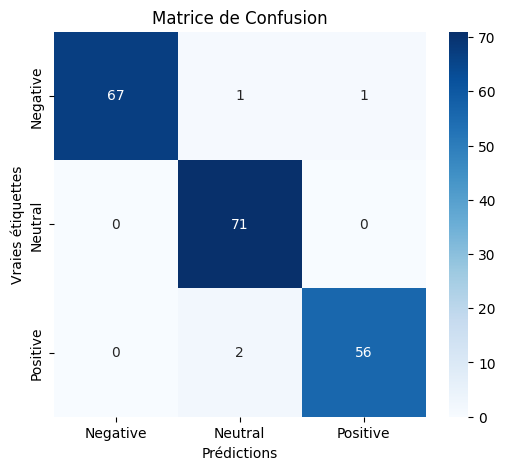

In [ ]:
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Enregistrer le modèle et le tokenizer sur Google Drive
model.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned")

('/content/drive/MyDrive/deberta_lora_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/spm.model',
 '/content/drive/MyDrive/deberta_lora_finetuned/added_tokens.json',
 '/content/drive/MyDrive/deberta_lora_finetuned/tokenizer.json')

#**Train DeBERTa 50 epochs**

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score
import numpy as np

# Définir la fonction pour calculer les métriques

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4.489352544691408e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Entraînement
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-1c125e88e105>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.416600,0.231656
2,0.291400,0.148122
3,0.134500,0.117985
4,0.073100,0.131747
5,0.245900,0.114845
6,0.142600,0.117719
7,0.236000,0.113277
8,0.174200,0.107015
9,0.087100,0.105910
10,0.055000,0.117694


TrainOutput(global_step=2500, training_loss=0.09103701809346676, metrics={'train_runtime': 909.2642, 'train_samples_per_second': 43.552, 'train_steps_per_second': 2.749, 'total_flos': 2613908811571200.0, 'train_loss': 0.09103701809346676, 'epoch': 50.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les prédictions du modèle
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Extraire les vraies étiquettes
true_labels = test_dataset["labels"]

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average="macro")
report = classification_report(true_labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Affichage des résultats
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}\n")

print("📊 Rapport de Classification :\n", report)

Accuracy  : 0.9747
Precision : 0.9736
Recall    : 0.9736
F1-score  : 0.9736

📊 Rapport de Classification :
               precision    recall  f1-score   support

    Negative       0.99      0.99      0.99        74
     Neutral       0.96      0.96      0.96        54
    Positive       0.97      0.97      0.97        70

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



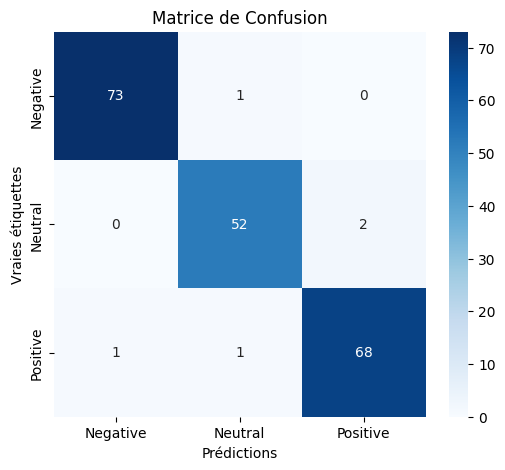

In [ ]:
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
# Enregistrer le modèle et le tokenizer sur Google Drive
model.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned50epochs")
tokenizer.save_pretrained("/content/drive/MyDrive/deberta_lora_finetuned50epochs")

('/content/drive/MyDrive/deberta_lora_finetuned50epochs/tokenizer_config.json',
 '/content/drive/MyDrive/deberta_lora_finetuned50epochs/special_tokens_map.json',
 '/content/drive/MyDrive/deberta_lora_finetuned50epochs/spm.model',
 '/content/drive/MyDrive/deberta_lora_finetuned50epochs/added_tokens.json',
 '/content/drive/MyDrive/deberta_lora_finetuned50epochs/tokenizer.json')

#**QLoRA**

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
)

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score
import numpy as np

# Charger le modèle quantifié en 4 bits
model = AutoModelForSequenceClassification.from_pretrained(
     "nickmuchi/deberta-v3-base-finetuned-finance-text-classification",
     num_labels=3,
     quantization_config=bnb_config,

)

lora_config = LoraConfig(
    r=4,  # Réduire la taille du rang
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
# Définir la fonction pour calculer les métriques

split = dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
test_dataset = split["test"]

training_args = TrainingArguments(
    output_dir="./qlora_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    push_to_hub=False,
    max_grad_norm=1.0,  # Ajouter un clip des gradients ici
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Entraînement
trainer.train()

`low_cpu_mem_usage` was None, now default to True since model is quantized.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-89746bf1f133>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.319800,nan
2,0.000000,nan
3,0.000000,nan


KeyboardInterrupt: 

#**Quantification 8-bit**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
model_path = "/content/drive/MyDrive/deberta_lora_finetuned50epochs"


In [4]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [5]:
from google.colab import drive
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig


drive.mount('/content/drive')
model_save_path = "/content/drive/MyDrive/DeBERTaQuantized"

# Quantification 8-bit
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

# Charger le modèle avec quantification
model = AutoModelForSequenceClassification.from_pretrained(
   model_path,
    num_labels=3,
    quantization_config=bnb_config,
    device_map={"": 0}
)

# Sauvegarder le modèle quantifié
model.save_pretrained(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modèle sauvegardé à : /content/drive/MyDrive/DeBERTaQuantized


In [16]:
def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return label_mapping[predicted_class], probabilities

tokenizer = AutoTokenizer.from_pretrained(model_path)
text = "La société \"ENNAKL\" tiendra une communication financière le Lundi 12 Février à 15h au siège de la Bourse de Tunis."
prediction, probs = predict(text, model, tokenizer)
print(f"Prediction: {prediction}, Probabilities: {probs}")


Prediction: neutral, Probabilities: tensor([[1.4696e-03, 9.9756e-01, 8.5449e-04]], device='cuda:0',
       dtype=torch.float16)


In [17]:
from transformers import AutoTokenizer
import torch

def batch_predict(texts, model, tokenizer):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_classes = torch.argmax(probabilities, dim=-1).tolist()

    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predictions = [label_mapping[pred] for pred in predicted_classes]

    return list(zip(predictions, probabilities.cpu().tolist()))

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Liste d'actualités financières
news_list = [
    # Positives
    "L'économie tunisienne affiche une croissance solide en 2025. Après plusieurs années de difficultés économiques, la Tunisie enregistre une croissance du PIB de 3,8%, portée par la reprise des exportations agricoles et une augmentation des investissements étrangers.",
    "La BIAT enregistre une hausse record de ses bénéfices. Grâce à une politique de diversification de ses produits bancaires et une gestion optimisée des risques, la Banque Internationale Arabe de Tunisie affiche un résultat net en hausse de 15%, atteignant 1,2 milliard de dinars.",
    "Le secteur technologique tunisien attire des investisseurs internationaux. Des géants de la tech, comme Microsoft et Huawei, annoncent des investissements dans des start-ups tunisiennes spécialisées en intelligence artificielle et cybersécurité, positionnant le pays comme un hub technologique en Afrique du Nord.",
    "Le tourisme tunisien dépasse les prévisions en 2025. Avec plus de 9 millions de visiteurs enregistrés, le secteur du tourisme tunisien connaît une croissance exceptionnelle, stimulée par le retour des touristes européens et l’amélioration des infrastructures hôtelières.",
    "Une startup tunisienne révolutionne le secteur des paiements numériques. La fintech 'TuniPay' lève 10 millions de dollars auprès d’investisseurs étrangers pour étendre ses services de paiement mobile et faciliter les transactions numériques sur le continent africain.",
    "L’Union Européenne accorde un financement de 500 millions d’euros à la Tunisie. Destiné à soutenir la transition énergétique et l’innovation industrielle, cet investissement vise à accélérer la modernisation des infrastructures et favoriser l’emploi dans les secteurs stratégiques.",
    "Les exportations tunisiennes de produits agricoles enregistrent une augmentation de 8% en 2025, boostées par la demande internationale pour des produits biologiques et un climat favorable aux cultures.",
    "La banque centrale tunisienne annonce une nouvelle politique monétaire plus souple, visant à soutenir les petites et moyennes entreprises tout en garantissant la stabilité des prix dans l’économie.",
    "Le gouvernement tunisien met en place des incitations fiscales pour encourager les investissements dans le secteur des énergies renouvelables, avec des projets solaires et éoliens prévus pour 2026.",
    "Le secteur des télécommunications tunisien fait un bond en avant avec l’arrivée de nouvelles entreprises sur le marché, promettant de stimuler la compétitivité et réduire les coûts pour les consommateurs.",

    # Négatives
    "La Tunisie est confrontée à une crise de la dette extérieure, avec un montant record de 30 milliards de dollars en 2025, ce qui menace la stabilité économique du pays et complique la gestion des finances publiques.",
    "La Banque Centrale de Tunisie alerte sur la dépréciation continue du dinar tunisien, avec des pertes importantes contre l’euro et le dollar, ce qui impacte l'importation de biens essentiels et crée de l'inflation.",
    "L'instabilité politique qui secoue la Tunisie depuis 2023 affecte gravement les investissements étrangers, avec une chute de 25% des projets d’investissement en 2025 par rapport à l’année précédente.",
    "Les pénuries de matières premières, notamment de carburant et de blé, continuent de frapper le pays, entraînant une hausse des prix alimentaires et un mécontentement croissant parmi la population.",
    "L'augmentation de la fiscalité pour combler le déficit budgétaire a créé un climat d'instabilité économique, affectant négativement les PME et réduisant leur capacité à créer de l’emploi.",
    "Les nouvelles réformes économiques ne parviennent pas à redresser la situation du marché de l’emploi, avec un taux de chômage des jeunes qui reste supérieur à 40% malgré les efforts gouvernementaux.",
    "Les institutions financières internationales avertissent que la Tunisie pourrait faire face à une crise de liquidité imminente si des réformes urgentes ne sont pas mises en place dans les mois à venir.",
    "Les importations de produits alimentaires ont connu une hausse dramatique de 15% en 2025, créant une pression sur les réserves en devises et aggravant la dépendance du pays vis-à-vis des marchés extérieurs.",
    "La crise sanitaire prolongée a mis à mal l’industrie du tourisme tunisien, dont les recettes ont chuté de près de 40% depuis 2020, avec des perspectives de reprise incertaines.",
    "Les entreprises tunisiennes peinent à s’adapter aux exigences du marché international, avec une productivité qui stagne et une absence de réformes structurelles profondes dans l’industrie.",

    # Neutres
    "Le marché immobilier tunisien connaît une stabilité relative en 2025, avec une légère hausse des prix dans les grandes villes, mais une demande modérée pour les nouveaux projets résidentiels.",
    "Le gouvernement tunisien a annoncé un plan de restructuration des entreprises publiques pour améliorer leur efficacité, sans toutefois indiquer de mesures précises pour éviter une réduction des emplois dans ces secteurs.",
    "Les discussions sur l’accord de libre-échange entre la Tunisie et l’Union Européenne sont en cours, mais des points de friction persistent concernant l'accès au marché agricole européen.",
    "Le prix des matières premières a montré une tendance à la baisse dans la première moitié de 2025, ce qui pourrait avoir un effet bénéfique pour les industries locales dépendantes des importations.",
    "Les relations diplomatiques entre la Tunisie et ses partenaires économiques s’améliorent, avec des accords commerciaux bilatéraux signés, bien que les résultats à long terme restent incertains.",
    "L'inflation en Tunisie a légèrement ralenti au cours des derniers mois, mais les experts prévoient que la pression sur les prix pourrait reprendre en raison de l'augmentation des coûts de l'énergie.",
    "La politique gouvernementale de soutien aux secteurs agricoles commence à montrer des résultats positifs, mais les effets sur la durabilité à long terme restent encore à évaluer.",
    "Le marché boursier tunisien connaît une volatilité modérée en 2025, avec des fluctuations qui n’ont pas encore eu d’impact majeur sur les grandes entreprises cotées.",
    "La révision de la politique fiscale a pour objectif de simplifier le système, mais les entreprises locales expriment des préoccupations quant à la mise en œuvre des nouvelles mesures.",
    "L'extension de la couverture des services de santé en Tunisie permet à un plus grand nombre de citoyens d'accéder à des soins médicaux, mais les défis liés à la qualité et à l'infrastructure restent présents."
]

for news in news_list:
    prediction, probs = predict(news, model, tokenizer)
    print(f"- {news}")
    print(f"    Prediction: {prediction}, Probabilities: {probs}\n")


- L'économie tunisienne affiche une croissance solide en 2025. Après plusieurs années de difficultés économiques, la Tunisie enregistre une croissance du PIB de 3,8%, portée par la reprise des exportations agricoles et une augmentation des investissements étrangers.
    Prediction: positive, Probabilities: tensor([[5.7220e-04, 2.2721e-04, 9.9902e-01]], device='cuda:0',
       dtype=torch.float16)

- La BIAT enregistre une hausse record de ses bénéfices. Grâce à une politique de diversification de ses produits bancaires et une gestion optimisée des risques, la Banque Internationale Arabe de Tunisie affiche un résultat net en hausse de 15%, atteignant 1,2 milliard de dinars.
    Prediction: positive, Probabilities: tensor([[3.8266e-04, 1.0376e-03, 9.9854e-01]], device='cuda:0',
       dtype=torch.float16)

- Le secteur technologique tunisien attire des investisseurs internationaux. Des géants de la tech, comme Microsoft et Huawei, annoncent des investissements dans des start-ups tunisien